In [56]:
from utilities import *
import matplotlib as mpl
import matplotlib.pyplot as plt
import reproject
import radio_beam
import os
from astropy.convolution import convolve
from astropy.io import fits
from astropy.wcs import WCS

plt.rcParams['figure.dpi'] = 300

source='DSi'
fnum=fields[source]
central_pix=pixdict[source]
c2h5oh_sourcelocs={'DSi':'/oct2024_1_removesDS2exclusions/','DSii':'/oct2024_1_removeproblemlines/',
                   'DSiii':'/dec2024_3_try-close-to-FWZI/','DSiv':'/nov2024_1_firstrun_removesDS2exclusions/',
                   'DSVI':'/nov2024_1_removesDS2exclusions/'}
ch3oh_datadir=f'/blue/adamginsburg/d.jeff/imaging_results/SgrB2DS-CH3OH/sep2023revolution/'#SgrB2S lives in the pacman_sep2023revolution folder, if we ever get to it
c2h5oh_datadir=f'/blue/adamginsburg/d.jeff/SgrB2DSreorg/field{fnum}/C2H5OH/{source}'+c2h5oh_sourcelocs[source]
ch3oh_datadir=f'/blue/adamginsburg/d.jeff/SgrB2DSreorg/field{fnum}/CH3OH/{source}/{ch3oh_sourcedict[source]}'

In [57]:
path_nh2=ch3oh_datadir+'bootstrap_nh2map_3sigma_bolocamfeather_smoothedtobolocam.fits'
path_error_nh2=ch3oh_datadir+'bootstrap_nh2map_error_bolocamfeather_smoothedtobolocam.fits'

path_c2h5oh_trot=c2h5oh_datadir+'texmap_3sigma_allspw_withnans_weighted.fits'
path_error_c2h5oh_trot=c2h5oh_datadir+'texmap_error_allspw_withnans_weighted.fits'

In [58]:
hdu_nh2=fits.open(path_nh2)
beam_nh2=radio_beam.Beam.from_fits_header(hdu_nh2[0].header)
data_nh2=hdu_nh2[0].data
error_nh2=fits.getdata(path_error_nh2)
nh2wcs=WCS(hdu_nh2[0].header)

hdu_c2h5oh_trot=fits.open(path_c2h5oh_trot)
beam_c2h5oh_trot=radio_beam.Beam.from_fits_header(hdu_c2h5oh_trot[0].header)
data_c2h5oh_trot=hdu_c2h5oh_trot[0].data

hdu_error_c2h5oh_trot=fits.open(path_error_c2h5oh_trot)
beam_error_c2h5oh_trot=radio_beam.Beam.from_fits_header(hdu_error_c2h5oh_trot[0].header)
error_c2h5oh_trot=hdu_error_c2h5oh_trot[0].data

beam_deconv=beam_nh2.deconvolve(beam_c2h5oh_trot)
pixscale=WCS(hdu_c2h5oh_trot[0].header).proj_plane_pixel_area()**0.5

snr_trot=data_c2h5oh_trot/error_c2h5oh_trot
if source == 'DSiv':
    trot_okmask=(data_c2h5oh_trot<=750)*(data_c2h5oh_trot>=20)
    okmask=trot_okmask*(snr_trot<=15)
else:
    trot_okmask=(data_c2h5oh_trot<=400)*(data_c2h5oh_trot>=20)
    okmask=trot_okmask*(snr_trot<=11)
preconvolve_ok_trot=data_c2h5oh_trot*okmask

sanity_error_mask=np.isfinite(error_c2h5oh_trot)*(error_c2h5oh_trot < 150)
sanity_error_c2h5oh_trot=error_c2h5oh_trot*sanity_error_mask

nantreatment={'DSi':'interpolate','DSii':'interpolate','DSiv':'fill','DSVI':'fill'}
smoothed_c2h5oh_trot = convolve(preconvolve_ok_trot, beam_deconv.as_kernel(pixscale),nan_treatment=nantreatment[source])
#masked_smoothed_c2h5oh_trot=np.isfinite(data_nh2)*smoothed_c2h5oh_trot#*np.isfinite(preconvolve_ok_trot)
#masked_smoothed_c2h5oh_trot=smoothed_c2h5oh_trot*nh2mask
#okmaskc2h5ohtrot=np.ma.masked_where(okmask==False,smoothed_c2h5oh_trot)
#ok_smoothed_nc2h5oh=okmasknc2h5oh.filled(fill_value=np.nan)

#preconvolve_ok_error_nc2h5oh=okmask*error_nc2h5oh

smoothed_error_c2h5oh_trot = convolve(sanity_error_c2h5oh_trot, beam_deconv.as_kernel(pixscale),nan_treatment=nantreatment[source])#,mask=okmask,preserve_nan=True)
smoothed_snr=smoothed_c2h5oh_trot/smoothed_error_c2h5oh_trot
sigma3_data_c2h5oh_trot=smoothed_c2h5oh_trot*(smoothed_snr >= 3)
#okmaskerrornc2h5oh=np.ma.masked_where(okmask==False,smoothed_error_nc2h5oh)
#ok_smoothed_error_nc2h5oh=okmaskerrornc2h5oh.filled(fill_value=np.nan)

Set OBSGEO-B to   -23.022886 from OBSGEO-[XYZ].
Set OBSGEO-H to     5053.796 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
divide by zero encountered in divide


In [59]:
np.nanmin(snr_trot)

3.000307886344532

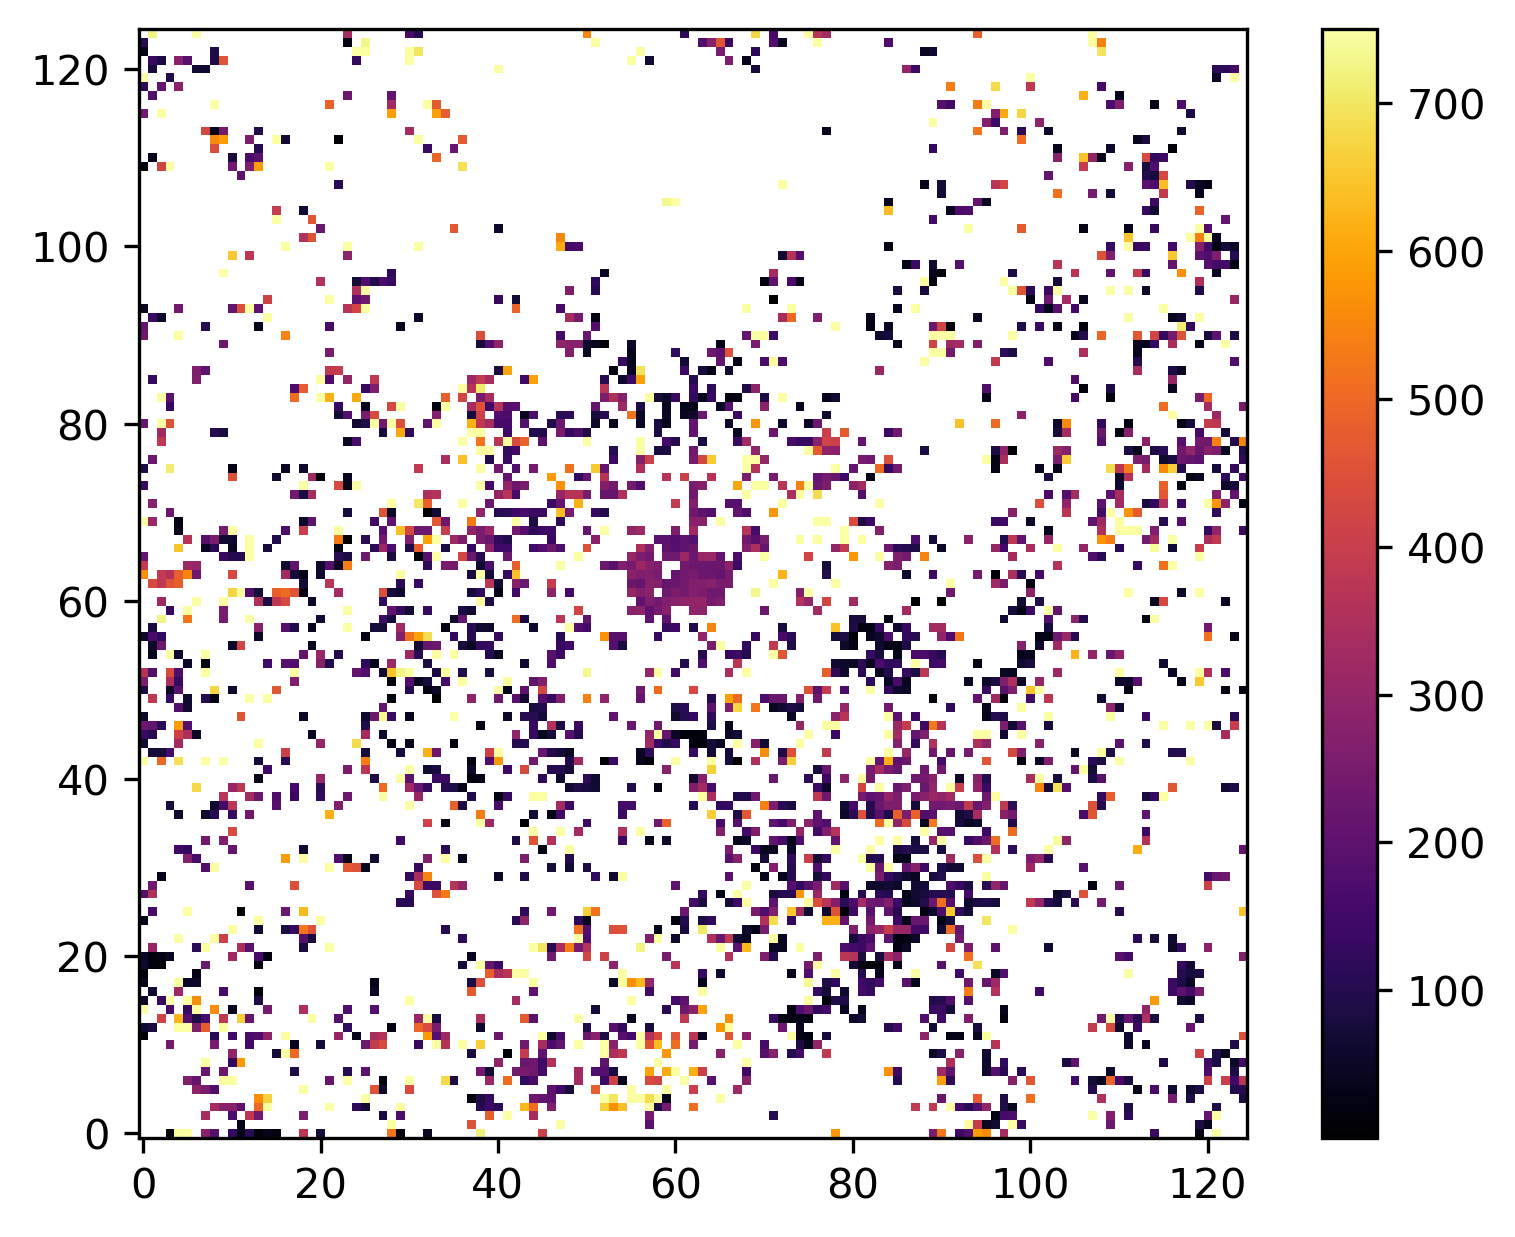

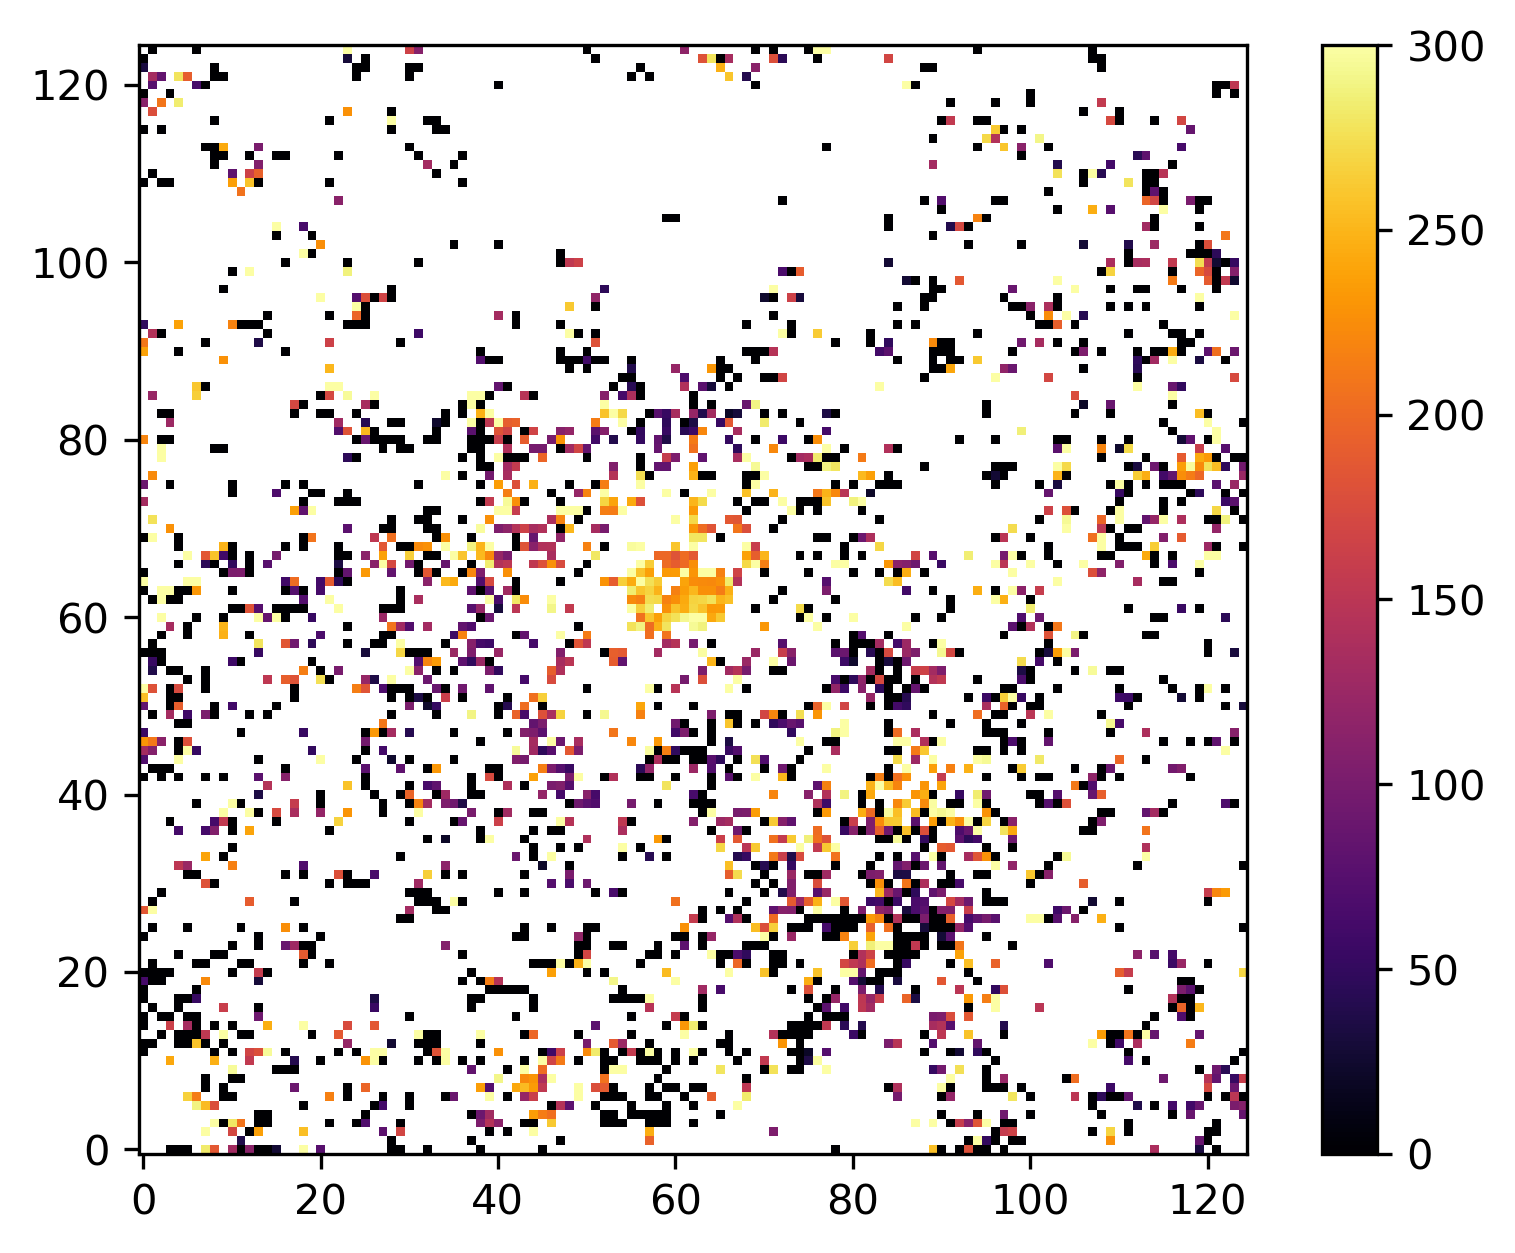

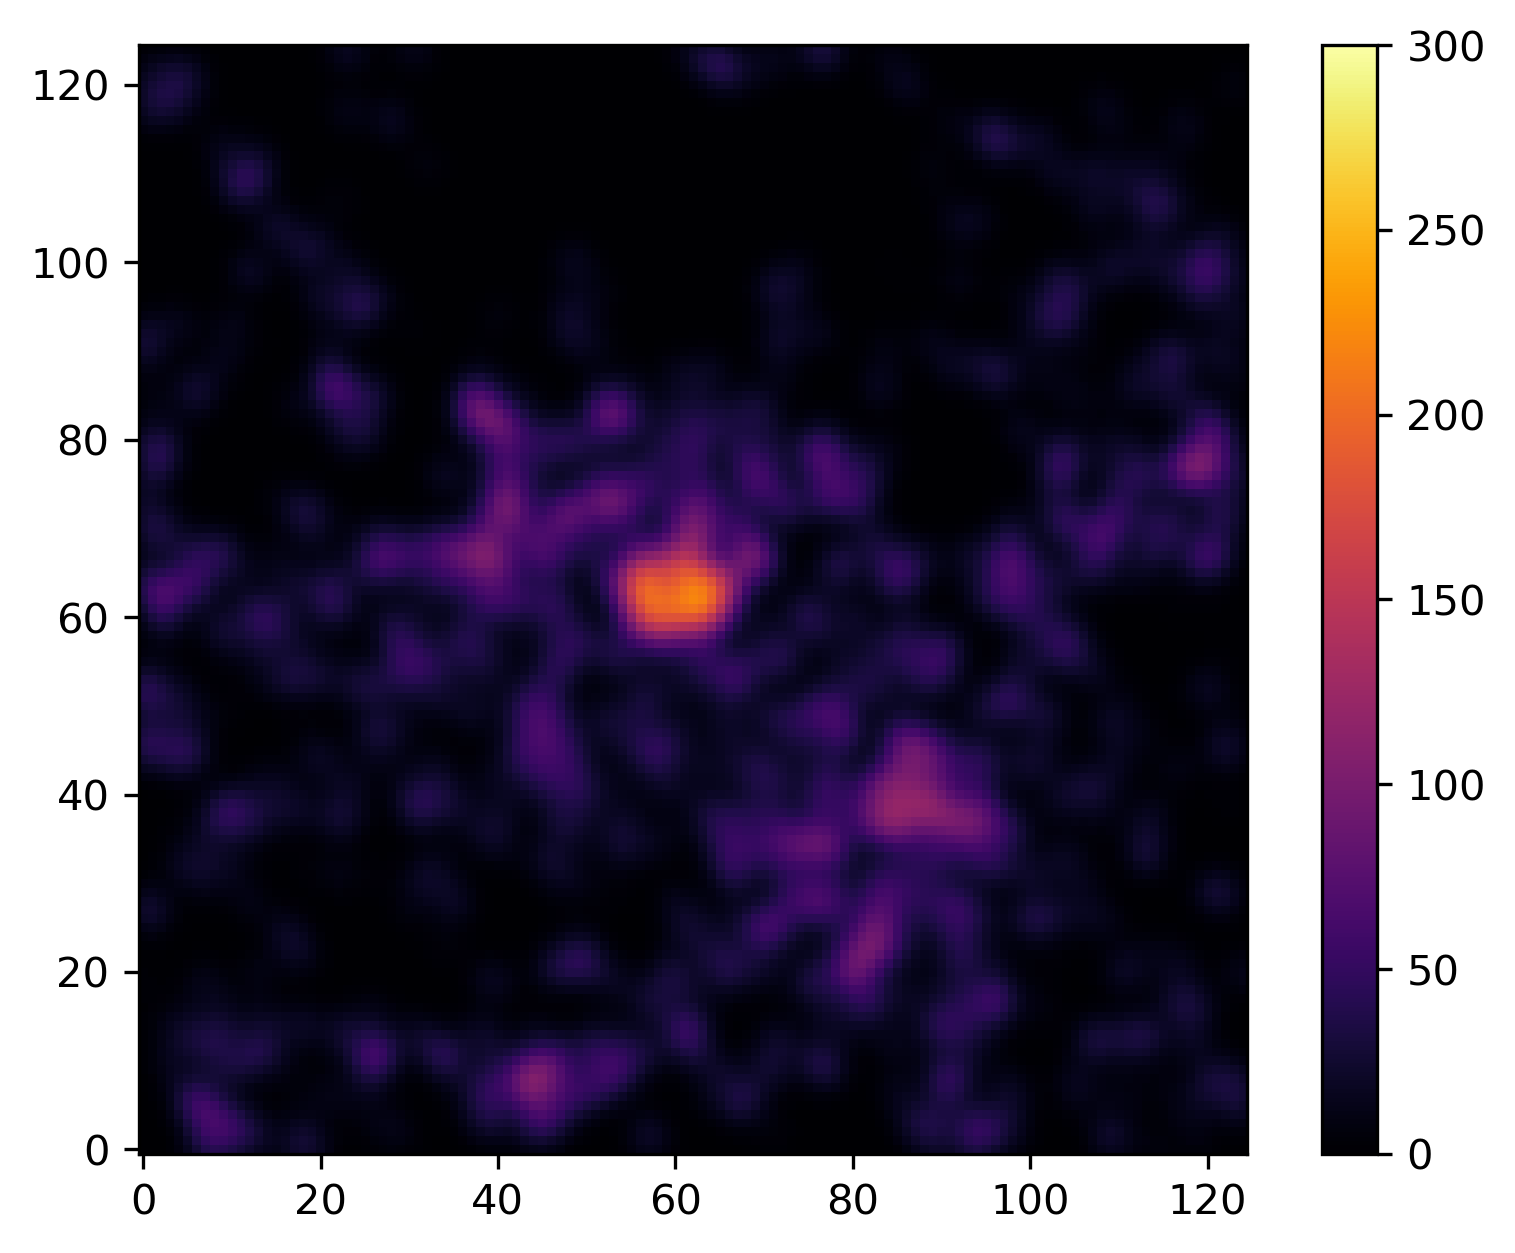

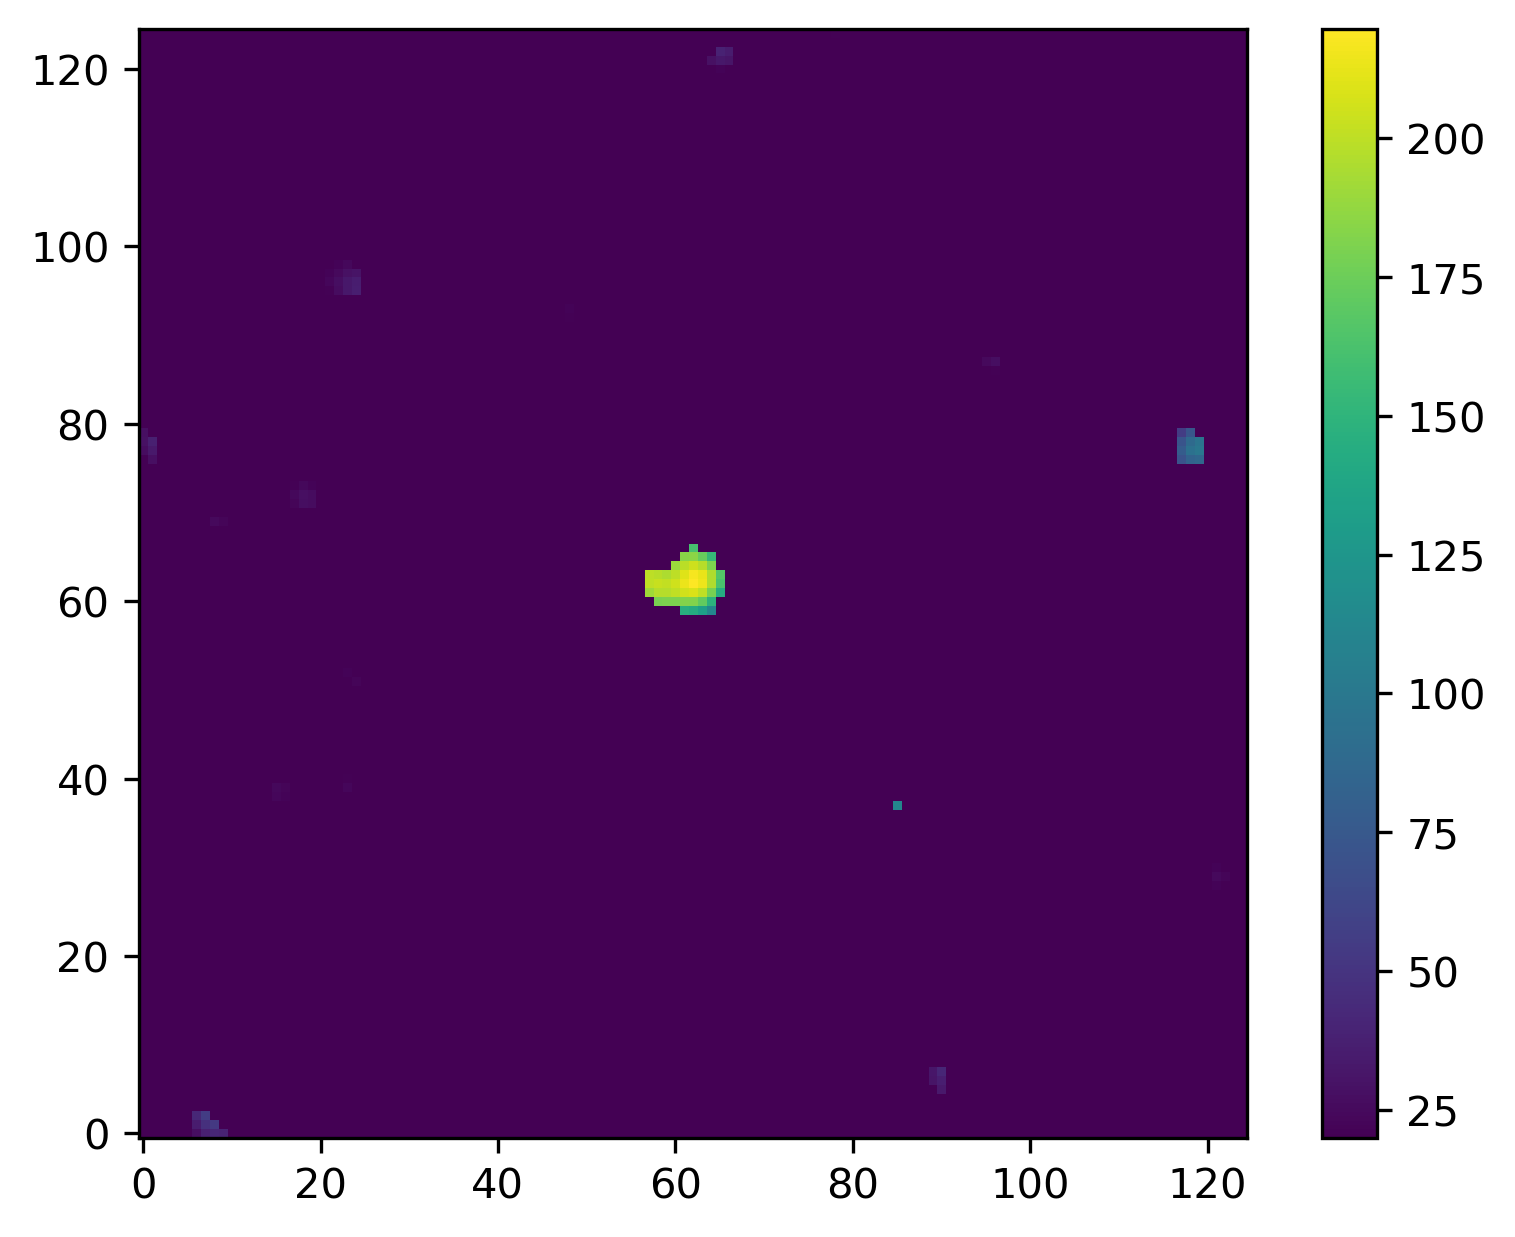

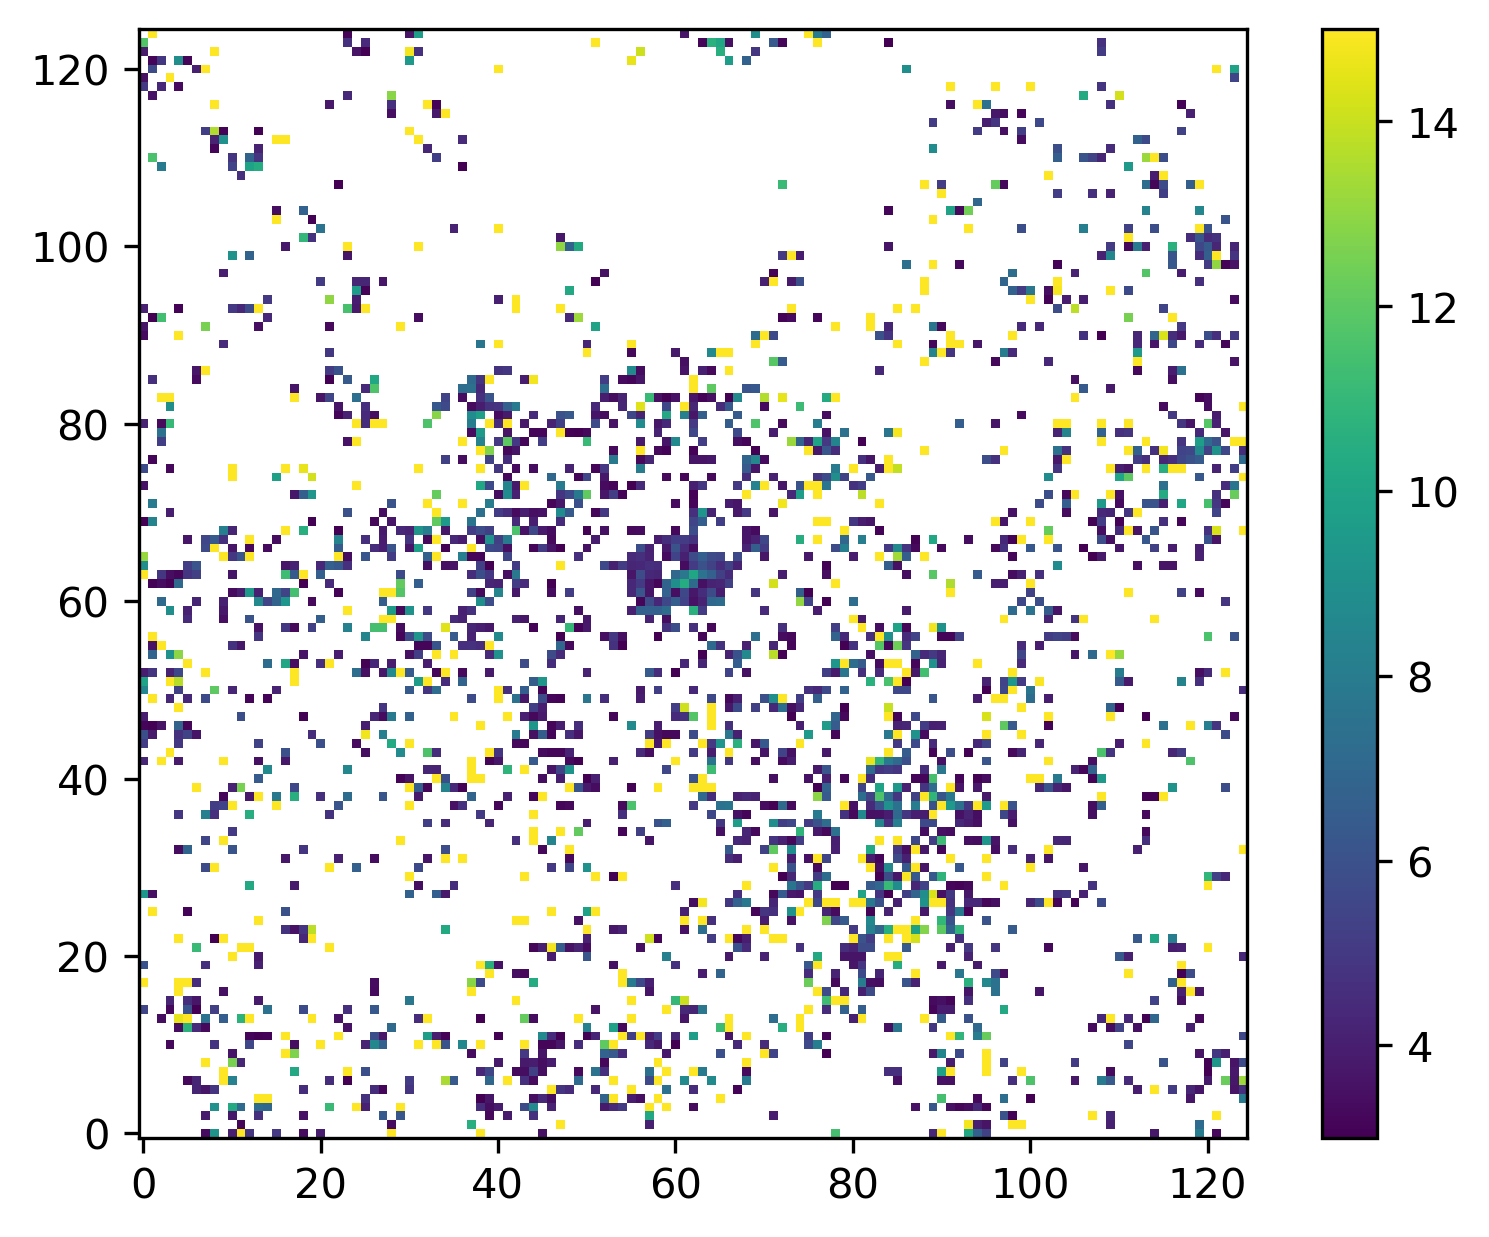

In [60]:
plt.imshow(data_c2h5oh_trot,origin='lower',vmax=750,cmap='inferno')
plt.colorbar()
plt.show()

plt.imshow(preconvolve_ok_trot,origin='lower',vmax=300,cmap='inferno')
plt.colorbar()
plt.show()

plt.imshow(smoothed_c2h5oh_trot,origin='lower',vmax=300,cmap='inferno')
plt.colorbar()
plt.show()

plt.imshow(sigma3_data_c2h5oh_trot,origin='lower',vmin=20)
plt.colorbar()
plt.show()

plt.imshow(snr_trot,origin='lower',vmax=15)
plt.colorbar()
plt.show()

In [62]:
sigma3_c2h5ohabundprimaryhdu=fits.PrimaryHDU(sigma3_data_c2h5oh_trot)
sigma3_c2h5ohabundprimaryhdu.header=hdu_nh2[0].header
sigma3_c2h5ohabundprimaryhdu.header['BTYPE']='Trot'
sigma3_c2h5ohabundprimaryhdu.header['BUNIT']='K'
sigma3_c2h5ohabundhdul=fits.HDUList([sigma3_c2h5ohabundprimaryhdu])
sigma3_c2h5ohabundfitspath=c2h5oh_datadir+f'smoothed_trot_{nantreatment[source]}_3sigma_bolocamfeather_smoothedtobolocam.fits'
print(f'Saving 3sigma C2H5OH map at {sigma3_c2h5ohabundfitspath}\n')
sigma3_c2h5ohabundhdul.writeto(sigma3_c2h5ohabundfitspath,overwrite=True)

c2h5ohabundprimaryhdu=fits.PrimaryHDU(smoothed_c2h5oh_trot)
c2h5ohabundprimaryhdu.header=hdu_nh2[0].header
c2h5ohabundprimaryhdu.header['BTYPE']='Trot'
c2h5ohabundprimaryhdu.header['BUNIT']='K'
c2h5ohabundhdul=fits.HDUList([c2h5ohabundprimaryhdu])
c2h5ohabundfitspath=c2h5oh_datadir+f'smoothed_trot_{nantreatment[source]}_bolocamfeather_smoothedtobolocam.fits'
print(f'Saving C2H5OH abundance map at {c2h5ohabundfitspath}\n')
c2h5ohabundhdul.writeto(c2h5ohabundfitspath,overwrite=True)

'''Not saving these yet since they the interpolator really struggles with nans and spuriously large values - 1/27/2025
errc2h5ohabundprimaryhdu=fits.PrimaryHDU(smoothed_error_c2h5oh_trot)
errc2h5ohabundprimaryhdu.header=hdu_nh2[0].header
errc2h5ohabundprimaryhdu.header['BTYPE']='Trot Error'
errc2h5ohabundprimaryhdu.header['BUNIT']='K'
errc2h5ohabundhdul=fits.HDUList([errc2h5ohabundprimaryhdu])
errc2h5ohabundfitspath=c2h5oh_datadir+f'smoothed_trot_error_bolocamfeather_smoothedtobolocam.fits'
print(f'Saving C2H5OH abundance error map at {errc2h5ohabundfitspath}\n')
errc2h5ohabundhdul.writeto(errc2h5ohabundfitspath,overwrite=True)
'''

Saving 3sigma C2H5OH map at /blue/adamginsburg/d.jeff/SgrB2DSreorg/field2/C2H5OH/DSVI/nov2024_1_removesDS2exclusions/smoothed_trot_fill_3sigma_bolocamfeather_smoothedtobolocam.fits

Saving C2H5OH abundance map at /blue/adamginsburg/d.jeff/SgrB2DSreorg/field2/C2H5OH/DSVI/nov2024_1_removesDS2exclusions/smoothed_trot_fill_bolocamfeather_smoothedtobolocam.fits



"Not saving these yet since they the interpolator really struggles with nans and spuriously large values - 1/27/2025\nerrc2h5ohabundprimaryhdu=fits.PrimaryHDU(smoothed_error_c2h5oh_trot)\nerrc2h5ohabundprimaryhdu.header=hdu_nh2[0].header\nerrc2h5ohabundprimaryhdu.header['BTYPE']='Trot Error'\nerrc2h5ohabundprimaryhdu.header['BUNIT']='K'\nerrc2h5ohabundhdul=fits.HDUList([errc2h5ohabundprimaryhdu])\nerrc2h5ohabundfitspath=c2h5oh_datadir+f'smoothed_trot_error_bolocamfeather_smoothedtobolocam.fits'\nprint(f'Saving C2H5OH abundance error map at {errc2h5ohabundfitspath}\n')\nerrc2h5ohabundhdul.writeto(errc2h5ohabundfitspath,overwrite=True)\n"